In [ ]:
#Importing Dataset


import pandas as pd
trader_df = pd.read_csv(r"C:\Users\pavan\Downloads\historical_data.csv")
sentiment_df = pd.read_csv(r"C:\Users\pavan\Downloads\fear_greed_index.csv")
trader_df.head()
sentiment_df.head()



,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [ ]:
trader_df.isnull().sum()


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [ ]:
trader_df.columns


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

In [ ]:
#Cleaning the Data

trader_df.columns = (
    trader_df.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.lower()
)


In [ ]:
trader_df.columns


Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')

In [ ]:
trader_df = trader_df.rename(columns={
    'closed_pnl': 'closedPnL',
    'execution_price': 'execution_price',
    'size_tokens': 'size_tokens',
    'size_usd': 'trade_value',
    'timestamp_ist': 'time',
    'side': 'side',
    'account': 'account',
    'coin': 'symbol'
})


In [ ]:
trader_df = trader_df.dropna(subset=['closedPnL'])


In [ ]:
trader_df = trader_df[
    (trader_df['execution_price'] > 0) &
    (trader_df['size_tokens'] > 0)
]



In [ ]:
trader_df['time'] = pd.to_datetime(
    trader_df['time'],
    dayfirst=True,
    errors='coerce'
)


In [ ]:
trader_df['time'].isna().sum()


np.int64(0)

In [ ]:
trader_df = trader_df.dropna(subset=['time'])


In [ ]:
trader_df['trade_date'] = trader_df['time'].dt.date


In [ ]:
trader_df[['time', 'trade_date']].head()


,time,trade_date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


In [ ]:
#Feature Engineering

trader_df['is_profitable'] = trader_df['closedPnL'] > 0


In [ ]:
trader_df['roi'] = trader_df['closedPnL'] / trader_df['trade_value']


In [ ]:
trader_df['net_pnl'] = trader_df['closedPnL'] - trader_df['fee']
trader_df['net_roi'] = trader_df['net_pnl'] / trader_df['trade_value']


In [ ]:
sentiment_df.columns


Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

In [ ]:
sentiment_df = sentiment_df.rename(columns={
    'Date': 'date',
    'Classification': 'sentiment'
})


In [ ]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], dayfirst=True, errors='coerce')


In [ ]:
trader_df['date'] = trader_df['time'].dt.date
sentiment_df['date_only'] = sentiment_df['date'].dt.date


In [ ]:
#Merging Trader data with Market Sentiment 

import pandas as pd
trader_df['date'] = trader_df['time'].dt.date 

sentiment_df = sentiment_df.rename(columns={
    'Date': 'date',
    'Classification': 'classification'   
})


sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], dayfirst=True)
sentiment_df['date_only'] = sentiment_df['date'].dt.date  # extract date only


sentiment_map = {
    'Extreme Fear': -2,
    'Fear': -1,
    'Neutral': 0,
    'Greed': 1,
    'Extreme Greed': 2
}
sentiment_df['sentiment_score'] = sentiment_df['classification'].map(sentiment_map)


merged_df = trader_df.merge(
    sentiment_df[['date_only', 'classification', 'sentiment_score']],
    left_on='date',
    right_on='date_only',
    how='left'
)

merged_df[['date', 'closedPnL', 'classification', 'sentiment_score']].head()


,date,closedPnL,classification,sentiment_score
0,2024-12-02,0.0,Greed,1.0
1,2024-12-02,0.0,Greed,1.0
2,2024-12-02,0.0,Greed,1.0
3,2024-12-02,0.0,Greed,1.0
4,2024-12-02,0.0,Greed,1.0


In [ ]:
#Exploratory Data Analysis

avg_pnl = merged_df.groupby('classification')['closedPnL'].mean()
print("Average PnL by sentiment:")
print(avg_pnl)


merged_df['is_profitable'] = merged_df['closedPnL'] > 0
win_rate = merged_df.groupby('classification')['is_profitable'].mean()
print("\nWin rate by sentiment:")
print(win_rate)


Average PnL by sentiment:
classification
Extreme Fear       1.891632
Extreme Greed    205.816345
Fear             128.287950
Greed             53.988003
Neutral           27.088803
Name: closedPnL, dtype: float64

Win rate by sentiment:
classification
Extreme Fear     0.292777
Extreme Greed    0.553282
Fear             0.381787
Greed            0.435707
Neutral          0.494920
Name: is_profitable, dtype: float64


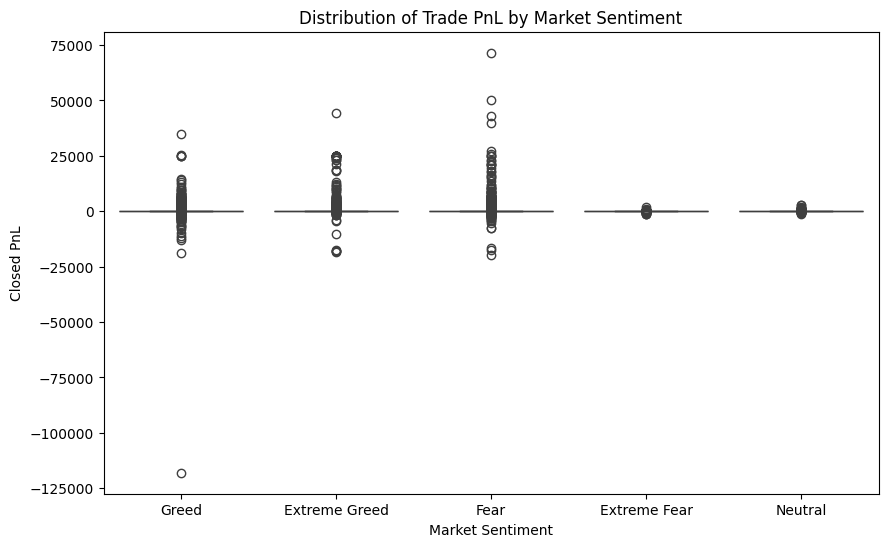

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.boxplot(x='classification', y='closedPnL', data=merged_df)
plt.title('Distribution of Trade PnL by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.show()


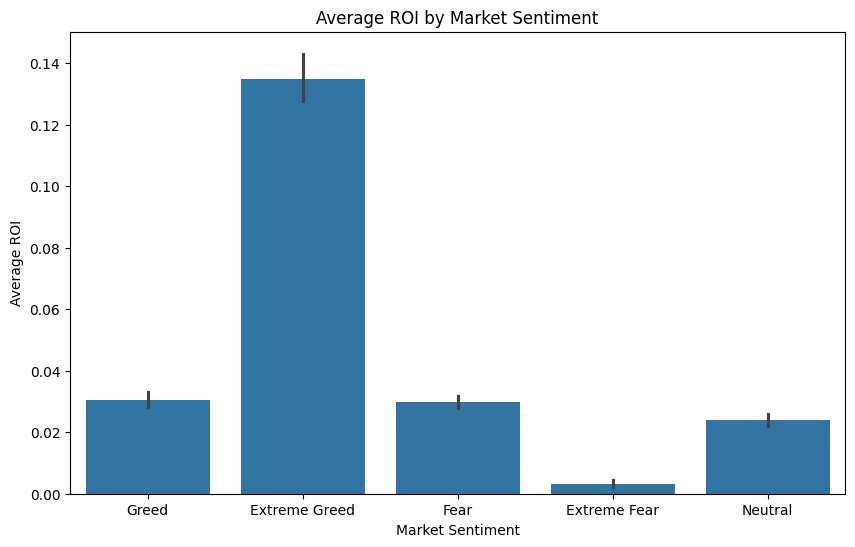

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='classification', y='roi', data=merged_df)
plt.title('Average ROI by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average ROI')
plt.show()


In [ ]:

correlation = merged_df['closedPnL'].corr(merged_df['sentiment_score'])
print(f"Correlation between sentiment_score and PnL: {correlation:.3f}")


Correlation between sentiment_score and PnL: 0.012


In [ ]:
trades_per_day_df = merged_df.groupby(['account', 'date']).size().reset_index(name='trades_per_day')
merged_df = merged_df.merge(trades_per_day_df, on=['account', 'date'], how='left')


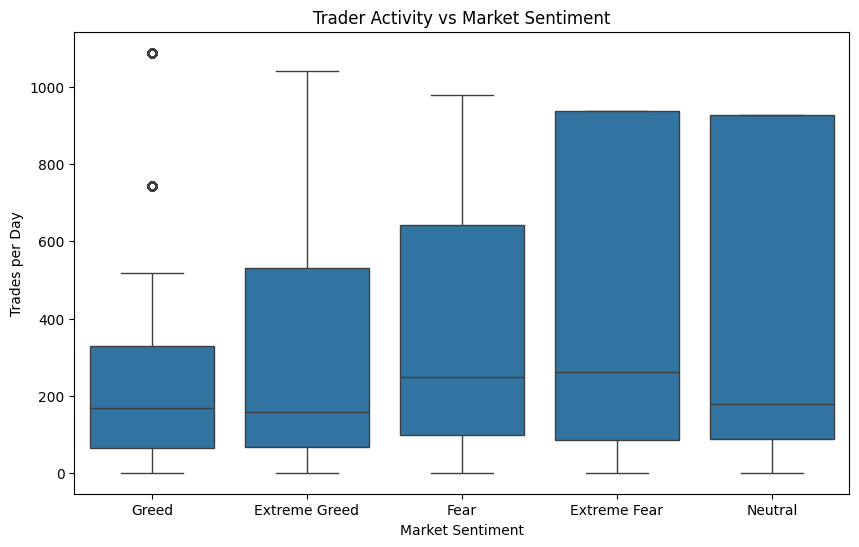

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(x='classification', y='trades_per_day', data=merged_df)
plt.title('Trader Activity vs Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Trades per Day')
plt.show()


In [ ]:
# Aggregate PnL and Win Rate per sentiment
performance = merged_df.groupby('classification').agg({
    'closedPnL': ['mean', 'sum'],
    'is_profitable': 'mean',
    'trades_per_day': 'mean'
}).reset_index()

performance.columns = ['Sentiment', 'Avg_PnL', 'Total_PnL', 'Win_Rate', 'Avg_Trades_per_Day']
performance


,Sentiment,Avg_PnL,Total_PnL,Win_Rate,Avg_Trades_per_Day
0,Extreme Fear,1.891632,4.399937e+03,0.292777,448.617369
1,Extreme Greed,205.816345,1.156894e+06,0.553282,336.502580
2,Fear,128.287950,1.779226e+06,0.381787,360.962506
3,Greed,53.988003,6.096325e+05,0.435707,291.057209
4,Neutral,27.088803,7.465674e+04,0.494920,390.316401


In [ ]:
# Best sentiment for profits
best_sentiment = performance.loc[performance['Avg_PnL'].idxmax(), 'Sentiment']

# Worst sentiment
worst_sentiment = performance.loc[performance['Avg_PnL'].idxmin(), 'Sentiment']

print(f"Best sentiment regime for profits: {best_sentiment}")
print(f"Worst sentiment regime for profits: {worst_sentiment}")


Best sentiment regime for profits: Extreme Greed
Worst sentiment regime for profits: Extreme Fear


In [ ]:
corr = merged_df['closedPnL'].corr(merged_df['sentiment_score'])
print(f"Correlation between sentiment_score and PnL: {corr:.3f}")


Correlation between sentiment_score and PnL: 0.012


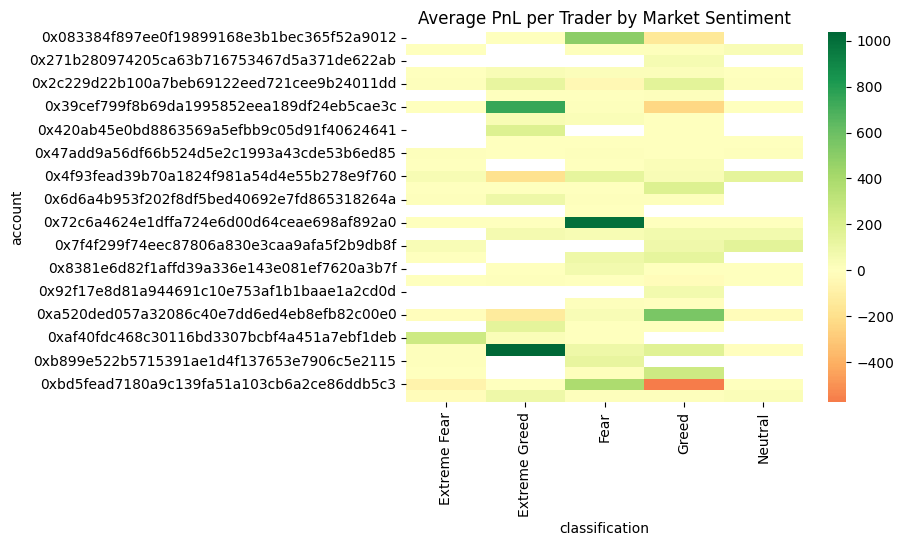

In [ ]:
# Pivot table of Average PnL per sentiment
heatmap_data = merged_df.pivot_table(
    index='account',
    columns='classification',
    values='closedPnL',
    aggfunc='mean'
)

sns.heatmap(heatmap_data, cmap='RdYlGn', center=0)
plt.title('Average PnL per Trader by Market Sentiment')
plt.show()
